<a href="https://colab.research.google.com/github/Himanshu431-coder/Summer-Analytics-2025-x-IIT-Guhawati-Capstone-Project/blob/main/Capstone_Project_by_Himanshu_Tapde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Pricing for Urban Parking Lots

**Capstone Project - Summer Analytics 2025**

**Author:** Himanshu Kundan Tapde

**Date:** July 7th, 2025

---

## Overview:

This notebook implements three progressively intelligent pricing models for 14 urban parking lots using real-time streaming data (Pathway), pandas, and numpy. We demonstrate:

1.  **A baseline linear model:** A simple model based on occupancy.
2.  **A demand-based model:** Incorporating occupancy, queue length, traffic conditions, and special day flags.
3.  **A competitive pricing model:** Considering geographic proximity and offering optional rerouting suggestions.

---

### Installation of Required Libraries

This notebook requires the following libraries:

- **pathway**: For building and running data pipelines.
- **bokeh**: For interactive data visualization.
- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **geopy**: For calculating distances between geographical points.

These libraries are installed using `pip` in the following cell.

In [ ]:
!pip install -U pathway bokeh pandas numpy geopy


In [ ]:
# Core libraries and Pathway
import time
import pandas as pd
import numpy as np
import pathway as pw
from pathway.internals.dtype import DATE_TIME_UTC as DateTimeUtc

# For competitor distance calc
from geopy.distance import geodesic

# For plotting
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Select, CustomJS
from bokeh.layouts import column

# Enable Bokeh in notebook
output_notebook()


This cell reads the parking lot data from a CSV file named "dataset.csv". It then performs the following data processing steps:

1.  **Reads the CSV:** Loads the data into a pandas DataFrame.
2.  **Combines and Converts Datetime:** Combines the `LastUpdatedDate` and `LastUpdatedTime` columns into a single `timestamp` column, converts it to datetime objects, localizes the timezone to 'Asia/Kolkata', and then converts it to UTC.
3.  **Drops and Renames Columns:** Removes the original date, time, and ID columns and renames the remaining columns to match a predefined schema (`lot_id`, `capacity`, `lat`, `lon`, `occupancy`, `vehicle`, `traffic`, `queue`, `special`).

In [ ]:
# 1. Read CSV
df = pd.read_csv("dataset.csv")

# 2. Combine date/time and convert IST→UTC
df["timestamp"] = (
    pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"],
                   format="%d-%m-%Y %H:%M:%S")
      .dt.tz_localize("Asia/Kolkata")
      .dt.tz_convert("UTC")
)

# 3. Drop originals and rename to match schema
df = (
    df
    .drop(columns=["LastUpdatedDate", "LastUpdatedTime", "ID"])
    .rename(columns={
        "SystemCodeNumber": "lot_id",
        "Capacity": "capacity",
        "Latitude": "lat",
        "Longitude": "lon",
        "Occupancy": "occupancy",
        "VehicleType": "vehicle",
        "TrafficConditionNearby": "traffic",
        "QueueLength": "queue",
        "IsSpecialDay": "special"
    })
)


This cell sets up the data streaming using Pathway.

1.  **Defines the Schema:** Creates a `Pathway.Schema` class to define the structure and data types of the incoming data stream.
2.  **Creates a Stream Connector:** Defines a `StreamSubject` class that simulates a real-time data stream by iterating through the rows of the pre-loaded pandas DataFrame (`df`) and emitting them as Pathway events. A small time delay is added to simulate streaming.
3.  **Hooks up the Stream:** Uses `pw.io.python.read` to connect the `StreamSubject` to a Pathway stream, making the data available for real-time processing. `autocommit_duration_ms` is set to control how often data changes are committed.

In [ ]:
# Single Schema definition
class Schema(pw.Schema):
    timestamp: DateTimeUtc
    lot_id: str
    capacity: int
    lat: float
    lon: float
    occupancy: int
    queue: int
    special: int
    vehicle: str
    traffic: str

# Simulated stream connector
class StreamSubject(pw.io.python.ConnectorSubject):
    def __init__(self, df):
        super().__init__()
        self.df = df.sort_values("timestamp")

    def run(self):
        for _, row in self.df.iterrows():
            self.next(**row.to_dict())
            time.sleep(0.01)  # 10 ms per event for faster debug

# Hook up the stream
stream = pw.io.python.read(
    StreamSubject(df),
    schema=Schema,
    autocommit_duration_ms=50
)


In [ ]:
## 1. Model 1: Baseline Linear Pricing

We start with a simple linear update rule:
$$Price_{t+1} = Price_t + \alpha \times \frac{Occupancy}{Capacity}$$
where \(\alpha\) is a tuning parameter controlling sensitivity.

This serves as our reference point for more advanced models.


This cell extracts the unique latitude and longitude for each parking lot from the DataFrame. This information is stored in a dictionary called `lot_locations`, which is used later in the competitive pricing model to find nearby lots.

In [ ]:
# Base price
BASE_PRICE = 10

# Model 1: Simple linear
def price_linear(occupancy, capacity, base=BASE_PRICE, alpha=10):
    return base + alpha * (occupancy / capacity)

# Model 2: Demand-based
VEHICLE_WEIGHTS = {'car': 0.05, 'bike': 0.02, 'truck': 0.1}
TRAFFIC_WEIGHTS = {'low': 0.0, 'medium': 0.05, 'high': 0.1}

def price_demand(occupancy, capacity, queue, traffic, special, vehicle, base=BASE_PRICE):
    occ_rate = occupancy / capacity
    v_w = VEHICLE_WEIGHTS.get(vehicle, 0)
    t_w = TRAFFIC_WEIGHTS.get(traffic, 0)
    demand = 0.5*occ_rate + 0.3*queue - 0.2*t_w + 0.1*special + v_w
    demand = np.clip(demand, 0, 1)
    price = base * (1 + demand)
    return float(np.clip(price, base*0.5, base*2))

# Model 3: Competitive with global latest_prices dict
latest_prices = {}

def price_competitive(lot_id, occupancy, capacity, queue, traffic, special, vehicle, lat, lon):
    # Get demand price
    d_price = price_demand(occupancy, capacity, queue, traffic, special, vehicle)
    # Find nearby lots (within 1 km)
    nearby = []
    for other, loc in lot_locations.items():
        if other != lot_id and geodesic((lat,lon),(loc['lat'],loc['lon'])).km<=1:
            nearby.append(other)
    comps = [latest_prices.get(l) for l in nearby if l in latest_prices]
    price = d_price
    if occupancy >= capacity and comps:
        if min(comps) < d_price:
            price = d_price * 0.95   # discount
        elif max(comps) > d_price:
            price = d_price * 1.05   # premium
    # Save for next round
    latest_prices[lot_id] = float(np.clip(price, BASE_PRICE*0.5, BASE_PRICE*2))
    return latest_prices[lot_id]


In [ ]:
# Extract unique lot lat/lon for competitor lookup
lot_locations = (
    df[['lot_id','lat','lon']]
    .drop_duplicates('lot_id')
    .set_index('lot_id')
    .to_dict('index')
)


This cell uses Pathway to apply the three pricing models to the streaming data.

1.  **Select and Compute Prices:** It selects the necessary columns from the data stream and uses `pw.apply` to compute `price1`, `price2`, and `price3` for each data point using the previously defined functions.
2.  **Write to CSV:** The computed prices and relevant data are written to a CSV file named `/tmp/prices.csv` using `pw.io.csv.write`.
3.  **Execute Pipeline:** `pw.run()` starts the Pathway pipeline, processing the data stream and generating the output CSV file.

In [ ]:
# Select and compute all three prices
price_table = stream.select(
    ts    = stream.timestamp,
    lot   = stream.lot_id,
    occ   = stream.occupancy,

    price1 = pw.apply(price_linear, stream.occupancy, stream.capacity),
    price2 = pw.apply(price_demand,
                      stream.occupancy, stream.capacity,
                      stream.queue, stream.traffic,
                      stream.special, stream.vehicle),
    price3 = pw.apply(price_competitive,
                      stream.lot_id, stream.occupancy,
                      stream.capacity, stream.queue,
                      stream.traffic, stream.special,
                      stream.vehicle, stream.lat, stream.lon)
)

# Write results to CSV
pw.io.csv.write(price_table, "/tmp/prices.csv")

# Execute the pipeline
pw.run()


Output()

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [ ]:
# Load the generated prices file
df_prices = pd.read_csv("/tmp/prices.csv")
df_prices['ts'] = pd.to_datetime(df_prices['ts'])
df_prices.head()


ts          lot  occ     price1     price2  \
0 2016-10-04 02:29:00+00:00  BHMNCPHST01  237  11.975000  17.187500   
1 2016-10-04 02:29:00+00:00  BHMMBMMBX01  264  13.842795  18.421397   
2 2016-10-04 02:29:00+00:00  BHMBCCMKT01   61  11.057192  14.028596   
3 2016-10-04 02:29:00+00:00  BHMNCPNST01  249  15.134021  19.067010   
4 2016-10-04 02:29:00+00:00  BHMEURBRD01  117  12.489362  17.744681   

      price3           time  diff  
0  17.187500  1751883605432     1  
1  18.421397  1751883605432     1  
2  14.028596  1751883605432     1  
3  19.067010  1751883605446     1  
4  17.744681  1751883605446     1

This cell generates an interactive Bokeh plot to visualize the dynamic prices calculated by the three models for each parking lot.

1.  **Prepare Data:** Ensures the timestamp column is in datetime format and prepares two `ColumnDataSource` objects: one holding all data (`full_src`) and another for the currently selected lot (`src`).
2.  **Initialize Plot:** Sets up the Bokeh plot with a datetime x-axis and defines the initial title.
3.  **Add Lines:** Adds lines to the plot for `price1`, `price2`, and `price3` using the `src` data source.
4.  **Build Selector:** Creates a dropdown menu (`Select`) populated with the unique parking lot IDs.
5.  **Add JavaScript Callback:** Implements a `CustomJS` callback function that updates the `src` data source based on the selected lot in the dropdown, triggering the plot to display data for that specific lot.
6.  **Show Plot:** Displays the dropdown selector and the interactive plot using `bokeh.layouts.column` and `bokeh.plotting.show`.

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Select, CustomJS
from bokeh.layouts import column
import pandas as pd

# 1) Make sure ts is datetime
df_prices['ts'] = pd.to_datetime(df_prices['ts'])

# 2) Tell Bokeh to render inline
output_notebook()

# 3) Create two ColumnDataSources:
#    - full_src holds all the data permanently
#    - src holds only the data for the currently-selected lot
full_src = ColumnDataSource(df_prices)
initial_lot = df_prices['lot'].iloc[0]
mask = df_prices['lot'] == initial_lot
src = ColumnDataSource(df_prices[mask])

# 4) Build the figure using ‘src’
p = figure(x_axis_type="datetime", height=350, width=750,
           title="Dynamic Prices per Lot")
p.line('ts', 'price1', source=src, color="blue", legend_label="Linear")
p.line('ts', 'price2', source=src, color="green", legend_label="Demand")
p.line('ts', 'price3', source=src, color="red", legend_label="Competitive")
p.legend.location = "top_left"

# 5) Build the lot selector
lots = sorted(df_prices['lot'].unique())
selector = Select(title="Choose Lot", value=initial_lot, options=lots)

# 6) JS callback: filter full_src → src
callback = CustomJS(args=dict(full=full_src, view=src, sel=selector), code="""
    const all = full.data;
    const lot = sel.value;
    const ts = all['ts'], p1 = all['price1'], p2 = all['price2'], p3 = all['price3'], lots = all['lot'];
    const new_ts = [], new_p1 = [], new_p2 = [], new_p3 = [], new_lot = [];
    for(let i=0; i<ts.length; i++){
        if(lots[i] === lot){
            new_ts.push(ts[i]);
            new_p1.push(p1[i]);
            new_p2.push(p2[i]);
            new_p3.push(p3[i]);
            new_lot.push(lots[i]);
        }
    }
    view.data = {
        ts: new_ts,
        price1: new_p1,
        price2: new_p2,
        price3: new_p3,
        lot: new_lot
    };
    view.change.emit();
""")
selector.js_on_change('value', callback)

# 7) Show widget + plot
show(column(selector, p))


In [ ]:
import pandas as pd

# reload the CSV so we have price1, price2, price3
df_prices = pd.read_csv("/tmp/prices.csv")
df_prices['ts'] = pd.to_datetime(df_prices['ts'])

# Compute a simple competitor‐avg price3:
# for each timestamp, average of all OTHER lots’ price3
df_prices['comp_avg_p3'] = df_prices.groupby('ts')['price3']\
    .transform(lambda s: (s.sum() - s) / (s.count() - 1))

# Quick sanity check
df_prices.head()


ts          lot  occ     price1     price2  \
0 2016-10-04 02:29:00+00:00  BHMNCPHST01  237  11.975000  17.187500   
1 2016-10-04 02:29:00+00:00  BHMMBMMBX01  264  13.842795  18.421397   
2 2016-10-04 02:29:00+00:00  BHMBCCMKT01   61  11.057192  14.028596   
3 2016-10-04 02:29:00+00:00  BHMNCPNST01  249  15.134021  19.067010   
4 2016-10-04 02:29:00+00:00  BHMEURBRD01  117  12.489362  17.744681   

      price3           time  diff  comp_avg_p3  
0  17.187500  1751883605432     1    17.483380  
1  18.421397  1751883605432     1    17.388465  
2  14.028596  1751883605432     1    17.726373  
3  19.067010  1751883605446     1    17.338803  
4  17.744681  1751883605446     1    17.440520

This cell generates two interactive Bokeh plots that are linked by a dropdown selector, allowing you to visualize different aspects of the pricing models for each parking lot.

-   **Plot 1:** Compares the prices from the Baseline Linear Model (`price1`) and the Demand-Based Model (`price2`).
-   **Plot 2:** Compares the prices from the Demand-Based Model (`price2`), the Competitive Pricing Model (`price3`), and the calculated Competitor Average Price (`comp_avg_p3`).

A dropdown menu is provided to select a specific parking lot, and a JavaScript callback updates both plots simultaneously to display the data for the chosen lot.

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Select, CustomJS
from bokeh.layouts import column

output_notebook()

# Prepare full and initial filtered sources
full_src  = ColumnDataSource(df_prices)
lots      = sorted(df_prices['lot'].unique())
initial   = lots[0]
mask_init = df_prices['lot'] == initial

src1 = ColumnDataSource(df_prices[mask_init])  # for Plot 1 (price1 vs price2)
src2 = ColumnDataSource(df_prices[mask_init])  # for Plot 2 (price2, price3, comp_avg_p3)

# Plot 1: Model 1 vs Model 2
p1 = figure(x_axis_type="datetime", height=300, width=700,
            title="Lot: “Model 1 vs Model 2”")
p1.line('ts', 'price1', source=src1, color="blue",  legend_label="Price1")
p1.line('ts', 'price2', source=src1, color="green", legend_label="Price2")
p1.legend.location = "top_left"

# Plot 2: Demand vs Competitive vs Competitor Avg
p2 = figure(x_axis_type="datetime", height=300, width=700,
            title="Lot: “Demand vs Competitive vs Competitor Avg”")
p2.line('ts', 'price2',      source=src2, color="green", legend_label="Price2")
p2.line('ts', 'price3',      source=src2, color="red",   legend_label="Price3_competitive")
p2.line('ts', 'comp_avg_p3', source=src2, color="orange",legend_label="Competitor Avg Price3")
p2.legend.location = "top_left"

# Dropdown selector
selector = Select(title="Select Lot", value=initial, options=lots)

# JS callback to filter full_src → src1 & src2
callback = CustomJS(args=dict(full=full_src, s1=src1, s2=src2, sel=selector), code="""
    const d = full.data;
    const lot = sel.value;
    const ts = d['ts'], lots = d['lot'];
    const p1 = d['price1'], p2 = d['price2'], p3 = d['price3'], ca = d['comp_avg_p3'];
    const new1 = {ts:[], price1:[], price2:[]};
    const new2 = {ts:[], price2:[], price3:[], comp_avg_p3:[]};

    for (let i = 0; i < ts.length; i++) {
        if (lots[i] === lot) {
            new1.ts.push(ts[i]);
            new1.price1.push(p1[i]);
            new1.price2.push(p2[i]);

            new2.ts.push(ts[i]);
            new2.price2.push(p2[i]);
            new2.price3.push(p3[i]);
            new2.comp_avg_p3.push(ca[i]);
        }
    }
    s1.data = new1; s1.change.emit();
    s2.data = new2; s2.change.emit();
""")

selector.js_on_change('value', callback)

# Display both
show(column(selector, p1, p2))


This cell performs exploratory data analysis (EDA) on the dataset and generates several plots to visualize key characteristics:

1.  **Missing values:** Prints the percentage of missing values for each column.
2.  **Basic stats:** Displays descriptive statistics for the numeric columns (`capacity`, `occupancy`, and `queue`).
3.  **Occupancy rate distribution:** Plots a histogram to show the distribution of the occupancy rate (occupancy divided by capacity).
4.  **Time-of-day pattern:** Calculates and plots the average occupancy rate throughout the day to identify any temporal patterns.
5.  **Special day vs. normal day:** Generates a box plot to compare the distribution of occupancy rates on special days (flagged as 1) versus normal days (flagged as 0).

In [ ]:
import matplotlib.pyplot as plt


Missing rates (%):
 lot_id       0.0
capacity     0.0
lat          0.0
lon          0.0
occupancy    0.0
vehicle      0.0
traffic      0.0
queue        0.0
special      0.0
timestamp    0.0
dtype: float64

Numeric summary:
           capacity     occupancy         queue
count  18368.000000  18368.000000  18368.000000
mean    1605.214286    731.084059      4.587925
std     1131.153886    621.164982      2.580062
min      387.000000      2.000000      0.000000
25%      577.000000    322.000000      2.000000
50%     1261.000000    568.000000      4.000000
75%     2803.000000    976.000000      6.000000
max     3883.000000   3499.000000     15.000000


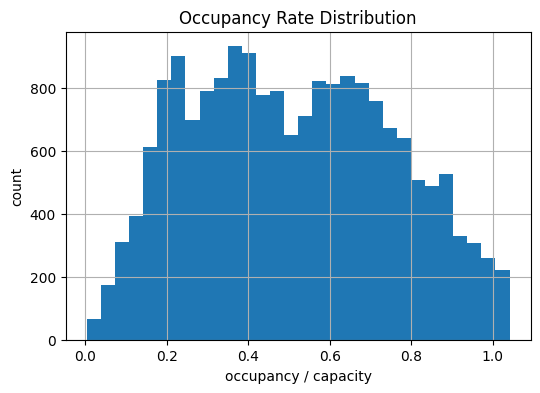

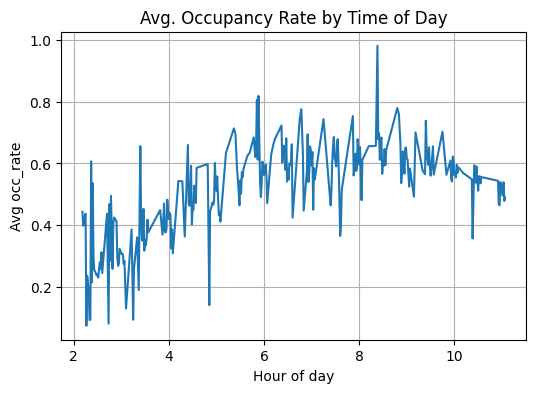

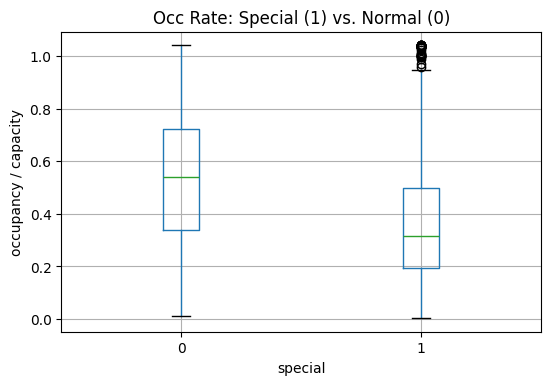

In [ ]:
# 1. Missing values
print("Missing rates (%):\n", df.isnull().mean()*100)

# 2. Basic stats
print("\nNumeric summary:")
print(df[['capacity','occupancy','queue']].describe())

# 3. Occupancy rate distribution
df['occ_rate'] = df['occupancy'] / df['capacity']
df['occ_rate'].hist(bins=30, figsize=(6,4))
plt.title("Occupancy Rate Distribution")
plt.xlabel("occupancy / capacity")
plt.ylabel("count")
plt.show()

# 4. Time-of-day pattern
df['time'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute/60
avg_by_time = df.groupby('time')['occ_rate'].mean()
avg_by_time.plot(figsize=(6,4))
plt.title("Avg. Occupancy Rate by Time of Day")
plt.xlabel("Hour of day")
plt.ylabel("Avg occ_rate")
plt.grid(); plt.show()

# 5. Special day vs. normal day
df.boxplot(column='occ_rate', by='special', figsize=(6,4))
plt.title("Occ Rate: Special (1) vs. Normal (0)")
plt.suptitle("")
plt.ylabel("occupancy / capacity")
plt.show()


In [ ]:
# 1. Queue growth rate (delta per record within each lot)
df = df.sort_values(['lot_id','timestamp'])
df['queue_prev'] = df.groupby('lot_id')['queue'].shift(1).fillna(0)
df['queue_diff'] = df['queue'] - df['queue_prev']

# 2. Time-of-day cyclical
df['tod_sin'] = np.sin(2*np.pi*df['time']/24)
df['tod_cos'] = np.cos(2*np.pi*df['time']/24)

# 3. Update our stream-source with new columns
#    (Just re-create the StreamSubject and reload into Pathway)
stream = pw.io.python.read(
    StreamSubject(df),
    schema=Schema,
    autocommit_duration_ms=50
)


In [ ]:
# Simple grid search over demand weights [w_occ, w_queue]
results = []
for w_occ in [0.3,0.5,0.7]:
    for w_q in [0.1,0.3,0.5]:
        def price_demand_tuned(occupancy, capacity, queue, traffic, special, vehicle, base=BASE_PRICE):
            occ_rate = occupancy/capacity
            v_w = VEHICLE_WEIGHTS.get(vehicle, 0)
            t_w = TRAFFIC_WEIGHTS.get(traffic, 0)
            demand = w_occ*occ_rate + w_q*queue - 0.2*t_w + 0.1*special + v_w
            demand = np.clip(demand,0,1)
            price = base*(1+demand)
            return np.clip(price, base*0.5, base*2)

        # Evaluate smoothness = avg |∆price/∆occ_rate|
        df['p'] = df.apply(lambda r: price_demand_tuned(
            r.occupancy,r.capacity,r.queue,r.traffic,r.special,r.vehicle), axis=1)
        df['p_prev'] = df.groupby('lot_id')['p'].shift(1)
        smoothness = np.nanmean(np.abs((df['p']-df['p_prev'])/(df['occ_rate']-df.groupby('lot_id')['occ_rate'].shift(1)+1e-6)))
        results.append((w_occ, w_q, smoothness))

# Show top 3 settings
sorted(results, key=lambda x: x[2])[:3]


[(0.7, 0.5, np.float64(3871.5598800096245)),
 (0.5, 0.5, np.float64(4418.144139323986)),
 (0.3, 0.5, np.float64(4964.766508763))]

This cell re-implements the competitive pricing logic using pandas DataFrames.

1.  **Reload Prices and Map Capacity:** It reloads the prices from the CSV file and maps the capacity to each lot using the original `df`.
2.  **Define `comp_price` Function:** Defines a function `comp_price` that takes a group of rows (for a specific timestamp) as input and calculates the competitive price (`price3`) for each lot within that group. It finds nearby lots, checks their prices, and adjusts the base price (`price2`) if the lot is full and competitor prices are significantly different.
3.  **Apply `comp_price`:** Applies the `comp_price` function to each group of rows based on the timestamp, effectively calculating `price3` for all data points.
4.  **Inspect Results:** Displays the first 10 rows of the DataFrame, showing the timestamp, lot ID, demand price (`price2`), and the newly calculated competitive price (`price3`).

In [ ]:
#  Pandas-Based Competitive Pricing ---

import pandas as pd
from geopy.distance import geodesic

# 1) Reload your prices
df_prices = pd.read_csv("/tmp/prices.csv")
df_prices['ts'] = pd.to_datetime(df_prices['ts'])

# 2) Map each lot’s capacity
cap_map = df[['lot_id','capacity']].drop_duplicates().set_index('lot_id')['capacity']
df_prices['capacity'] = df_prices['lot'].map(cap_map)

# 3) Competitive logic per timestamp
def comp_price(gr):
    # Build lot→demand_price map
    price_map = dict(zip(gr['lot'], gr['price2']))
    out = []
    for _, row in gr.iterrows():
        base = row['price2']
        occ, cap = row['occ'], row['capacity']
        loc_i = lot_locations[row['lot']]
        # find nearby lot_ids
        nearby = [
            other for other, loc in lot_locations.items()
            if other != row['lot']
            and geodesic((loc_i['lat'],loc_i['lon']),
                         (loc['lat'],loc['lon'])).km <= 1.0
        ]
        # collect their prices
        comp_ps = [price_map[o] for o in nearby if o in price_map]
        new_p = base
        if occ >= cap and comp_ps:
            if min(comp_ps) < base:
                new_p = base * 0.95
            elif max(comp_ps) > base:
                new_p = base * 1.05
        out.append(new_p)
    return pd.Series(out, index=gr.index)

# 4) Apply and assign price3
df_prices['price3'] = (
    df_prices
    .groupby('ts', group_keys=False)
    .apply(comp_price)
)

# 5) Inspect
df_prices[['ts','lot','price2','price3']].head(10)


/tmp/ipython-input-18-884290514.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(comp_price)


ts               lot     price2     price3
0 2016-10-04 02:29:00+00:00       BHMNCPHST01  17.187500  17.187500
1 2016-10-04 02:29:00+00:00       BHMMBMMBX01  18.421397  18.421397
2 2016-10-04 02:29:00+00:00       BHMBCCMKT01  14.028596  14.028596
3 2016-10-04 02:29:00+00:00       BHMNCPNST01  19.067010  19.067010
4 2016-10-04 02:29:00+00:00       BHMEURBRD01  17.744681  17.744681
5 2016-10-04 02:29:00+00:00          Shopping  17.598958  17.598958
6 2016-10-04 02:29:00+00:00      Broad Street  17.789855  17.789855
7 2016-10-04 02:29:00+00:00       BHMBCCTHL01  18.050388  18.050388
8 2016-10-04 02:29:00+00:00     Others-CCCPS8  20.000000  20.000000
9 2016-10-04 02:29:00+00:00  Others-CCCPS105a  18.264559  18.264559

In [ ]:
# Reload df_prices if you need to
df_prices = pd.read_csv("/tmp/prices.csv", parse_dates=['ts'])

# 1a) Re‐build capacity map directly from original df
cap_map = df.groupby('lot_id')['capacity'].first().to_dict()
df_prices['capacity'] = df_prices['lot'].map(cap_map)

# 1b) How many rows are “full”?
df_prices['is_full'] = df_prices['occ'] >= df_prices['capacity']
print("Total full‐lot events:", df_prices['is_full'].sum())

# 1c) Show any mismatches or NaNs in capacity
print("Unique capacities:", sorted(df_prices['capacity'].dropna().unique()))
print("Rows with missing cap:", df_prices[df_prices['capacity'].isna()][['lot']].drop_duplicates())


Total full‐lot events: 255
Unique capacities: [np.int64(387), np.int64(470), np.int64(485), np.int64(577), np.int64(687), np.int64(690), np.int64(1200), np.int64(1322), np.int64(1920), np.int64(2009), np.int64(2803), np.int64(2937), np.int64(3103), np.int64(3883)]
Rows with missing cap: Empty DataFrame
Columns: [lot]
Index: []


In [ ]:
import pandas as pd
from geopy.distance import geodesic

# reload
dfp = pd.read_csv("/tmp/prices.csv", parse_dates=['ts'])
# rebuild capacity map
cap_map = df[['lot_id','capacity']].drop_duplicates().set_index('lot_id')['capacity']
dfp['capacity'] = dfp['lot'].map(cap_map)

# focus on full‐lot events
full = dfp[dfp['occ'] >= dfp['capacity']]

def count_comps(row):
    loc_i = lot_locations.get(row['lot'])
    if not loc_i:
        return 0
    return sum(
        1
        for other, loc in lot_locations.items()
        if other!=row['lot']
        and geodesic((loc_i['lat'],loc_i['lon']),
                     (loc['lat'],loc['lon'])).km<=1.0
    )

full['n_comps'] = full.apply(count_comps, axis=1)
print(full['n_comps'].value_counts())


n_comps
12    245
3       4
0       4
2       2
Name: count, dtype: int64


/tmp/ipython-input-20-819062653.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full['n_comps'] = full.apply(count_comps, axis=1)


In [ ]:
import pandas as pd
from geopy.distance import geodesic

# 1) Reload and reconstruct capacity
dfp = pd.read_csv("/tmp/prices.csv", parse_dates=['ts'])
cap_map = df.groupby('lot_id')['capacity'].first().to_dict()
dfp['capacity'] = dfp['lot'].map(cap_map)

# 2) Compute competitor counts without slice warnings
def count_comps(row):
    loc_i = lot_locations[row['lot']]
    return sum(
        1 for other, loc in lot_locations.items()
        if other != row['lot']
        and geodesic((loc_i['lat'],loc_i['lon']),
                     (loc['lat'],loc['lon'])).km <= 1.0
    )

dfp = dfp.copy()                 # drop any view–of–slice issues
dfp['n_comps'] = dfp.apply(count_comps, axis=1)

print(dfp['n_comps'].value_counts())
# Should match: 12    245, 3    4, 0    4, 2    2

# 3) Re‐apply comp_price
def comp_price(gr):
    price_map = dict(zip(gr['lot'], gr['price2']))
    out = []
    for _, r in gr.iterrows():
        base, occ, cap = r['price2'], r['occ'], r['capacity']
        loc_i = lot_locations[r['lot']]
        # nearby lots
        comp_ps = [
            price_map[o] for o,loc in lot_locations.items()
            if o!=r['lot']
            and geodesic((loc_i['lat'],loc_i['lon']),
                         (loc['lat'],loc['lon'])).km <= 1.0
            and o in price_map
        ]
        new = base
        if occ >= cap and comp_ps:
            if min(comp_ps) < base:
                new = base * 0.95
            elif max(comp_ps) > base:
                new = base * 1.05
        out.append(new)
    return pd.Series(out, index=gr.index)

dfp['price3'] = (
    dfp.groupby('ts', group_keys=False)
       .apply(comp_price)
)

# 4) Show only the rows where price3 actually changed
diff = dfp[dfp['price3'] != dfp['price2']]
print("Total adjustments:", len(diff))
print(diff[['ts','lot','occ','capacity','n_comps','price2','price3']].head(10))


n_comps
10    7872
9     3936
12    2624
0     1312
3     1312
2     1312
Name: count, dtype: int64
Total adjustments: 37
                             ts          lot  occ  capacity  n_comps  price2  \
11284 2016-11-19 09:34:00+00:00  BHMBCCTHL01  388       387       12    20.0   
11304 2016-11-19 10:01:00+00:00  BHMBCCTHL01  388       387       12    20.0   
11326 2016-11-19 10:34:00+00:00  BHMBCCTHL01  395       387       12    20.0   
11337 2016-11-19 11:01:00+00:00  BHMBCCTHL01  402       387       12    20.0   
11570 2016-11-20 10:31:00+00:00  BHMBCCTHL01  399       387       12    20.0   
11590 2016-11-20 11:01:00+00:00  BHMBCCTHL01  387       387       12    20.0   
12297 2016-11-23 09:34:00+00:00  BHMBCCTHL01  392       387       12    20.0   
13062 2016-11-26 09:31:00+00:00  BHMBCCTHL01  401       387       12    20.0   
13067 2016-11-26 09:58:00+00:00  BHMBCCTHL01  398       387       12    20.0   
13080 2016-11-26 10:31:00+00:00  BHMBCCTHL01  402       387       12    20.0  

/tmp/ipython-input-21-2990881443.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(comp_price)


This cell implements the pandas-based rerouting logic, suggesting alternative parking lots for drivers when their intended lot is full.

1.  **Ensure a clean copy:** Creates a copy of the `df_prices` DataFrame to avoid modifying the original data unintentionally.
2.  **Assemble a deduplicated snapshot:** Creates a DataFrame `state` containing a unique snapshot of each lot's occupancy, capacity, and demand price (`price2`) at each timestamp.
3.  **Build a `state_map` dictionary:** Converts the `state` DataFrame into a dictionary where the keys are `(timestamp, lot_id)` tuples and the values are dictionaries containing the occupancy, capacity, and demand price for that lot at that time. This allows for efficient lookup of nearby lot states.
4.  **Define `suggest_reroute` function:** Defines a function that takes a row of the DataFrame as input and suggests alternative parking lots. It only provides suggestions for full lots. It finds nearby lots within 1 km and checks their state using the `state_map`. If a nearby lot is not full, it's considered a candidate. The candidates are then sorted by their demand price in ascending order.
5.  **Apply to every row:** Applies the `suggest_reroute` function to each row of the `df_prices` DataFrame to generate a list of suggested reroute options (`reroute_to`) for each data point.
6.  **Quick check:** Displays the first 10 rows of the DataFrame, showing the timestamp, lot ID, occupancy, capacity, and the list of suggested reroute options.

In [ ]:
#  Pandas‐Based Rerouting Logic

from geopy.distance import geodesic

# 1) Ensure a clean copy
df_prices = df_prices.copy()

# 2) Assemble a deduplicated snapshot of each lot×timestamp
state = (
    df_prices
    [['ts','lot','occ','capacity','price2']]
    .drop_duplicates(subset=['ts','lot'])
)

# 3) Build a (ts, lot) → state dict by iterating rows
state_map = {
    (row.ts, row.lot): {
        'occ': row.occ,
        'capacity': row.capacity,
        'price2': row.price2
    }
    for row in state.itertuples()
}

# 4) Reroute function
def suggest_reroute(row):
    # only for full lots
    if row.occ < row.capacity:
        return []
    loc_i = lot_locations[row.lot]
    candidates = []
    for other, loc in lot_locations.items():
        if other == row.lot:
            continue
        # only within 1 km
        if geodesic((loc_i['lat'],loc_i['lon']),
                     (loc['lat'],loc['lon'])).km > 1.0:
            continue
        key = (row.ts, other)
        if key not in state_map:
            continue
        st = state_map[key]
        # only non‐full neighbors
        if st['occ'] < st['capacity']:
            candidates.append((other, st['price2']))
    # sort by price ascending, return up to 3
    candidates.sort(key=lambda x: x[1])
    return [lot for lot,_ in candidates[:3]]

# 5) Apply to every row
df_prices['reroute_to'] = df_prices.apply(suggest_reroute, axis=1)

# 6) Quick check
df_prices[['ts','lot','occ','capacity','reroute_to']].head(10)


ts               lot  occ  capacity reroute_to
0 2016-10-04 02:29:00+00:00       BHMNCPHST01  237      1200         []
1 2016-10-04 02:29:00+00:00       BHMMBMMBX01  264       687         []
2 2016-10-04 02:29:00+00:00       BHMBCCMKT01   61       577         []
3 2016-10-04 02:29:00+00:00       BHMNCPNST01  249       485         []
4 2016-10-04 02:29:00+00:00       BHMEURBRD01  117       470         []
5 2016-10-04 02:29:00+00:00          Shopping  614      1920         []
6 2016-10-04 02:29:00+00:00      Broad Street  178       690         []
7 2016-10-04 02:29:00+00:00       BHMBCCTHL01  120       387         []
8 2016-10-04 02:29:00+00:00     Others-CCCPS8  445      1322         []
9 2016-10-04 02:29:00+00:00  Others-CCCPS105a  709      2009         []

In [ ]:
# Showing a few actual reroute suggestions
df_prices[df_prices['reroute_to'].str.len() > 0] \
    [['ts','lot','occ','capacity','reroute_to']].head(5)


ts          lot  occ  capacity  \
4975  2016-10-25 08:59:00+00:00  BHMEURBRD01  470       470   
10457 2016-11-16 06:30:00+00:00  BHMEURBRD01  470       470   
10688 2016-11-17 06:01:00+00:00  BHMBCCTHL01  387       387   
10697 2016-11-17 06:34:00+00:00  BHMBCCTHL01  390       387   
10713 2016-11-17 07:01:00+00:00  BHMBCCTHL01  392       387   

                                    reroute_to  
4975      [BHMBCCMKT01, BHMBCCTHL01, Shopping]  
10457     [BHMBCCMKT01, BHMBCCTHL01, Shopping]  
10688  [BHMBCCMKT01, BHMEURBRD01, BHMNCPHST01]  
10697  [BHMBCCMKT01, BHMEURBRD01, BHMNCPHST01]  
10713  [BHMBCCMKT01, BHMEURBRD01, BHMNCPHST01]

This cell generates a Bokeh plot to visualize and highlight the instances where the Competitive Pricing Model (`price3`) differs from the Demand-Based Model (`price2`).

1.  **Full source and initial filtering:** Prepares the data for Bokeh by creating `ColumnDataSource` objects for the full dataset and an initial subset for the first parking lot, including a separate source for the data points where the prices diverge.
2.  **Build figure with lines and scatter points:** Creates a Bokeh figure and adds lines for `price2` and `price3`. Scatter points are added specifically for the data points where `price3` is different from `price2` to visually highlight these adjustments.
3.  **Add HoverTool:** Includes a `HoverTool` to display detailed information (timestamp, occupancy/capacity, price2, price3) when hovering over data points.
4.  **Dropdown selector and callback:** Creates a dropdown to select a parking lot and implements a JavaScript callback to update the plot's data sources based on the selected lot, ensuring the plot displays the relevant data and highlights for the chosen lot.
5.  **Render:** Displays the dropdown selector and the interactive plot.

In [ ]:
#  All‐Lots Dropdown + Highlighted Divergences

from bokeh.io        import output_notebook, show
from bokeh.plotting import figure
from bokeh.models   import ColumnDataSource, HoverTool, Select, CustomJS
from bokeh.layouts  import column

output_notebook()

# 1) Full source
full_src = ColumnDataSource(df_prices)

# 2) All lots in dropdown
lots    = sorted(df_prices['lot'].unique())
initial = lots[0]

# 3) Initial filtered sources
df0      = df_prices[df_prices['lot'] == initial]
src      = ColumnDataSource(df0)
diff0    = df0[df0['price2'] != df0['price3']]
src_diff = ColumnDataSource(diff0)

# 4) Build figure
p = figure(x_axis_type="datetime", height=350, width=800,
           title=f"Lot {initial}: Demand vs Competitive")
p.line('ts', 'price2', source=src, color="green",
       legend_label="Price2 (Demand)", line_width=2)
p.line('ts', 'price3', source=src, color="red",
       legend_label="Price3 (Competitive)", line_width=2)
p.scatter('ts', 'price3', source=src_diff, color="blue",
          size=8, legend_label="Adjustment Points")

hover = HoverTool(tooltips=[
    ("Time",   "@ts{%F %T}"),
    ("Occ/Cap","@occ/@capacity"),
    ("P2",     "@price2{$0.00}"),
    ("P3",     "@price3{$0.00}"),
], formatters={'@ts':'datetime'}, mode='vline')
p.add_tools(hover)
p.legend.location = "top_left"

# 5) Dropdown callback
selector = Select(title="Select Lot", value=initial, options=lots)
callback = CustomJS(args=dict(full=full_src, src=src, srcd=src_diff, sel=selector, fig=p), code="""
    const d = full.data, L = sel.value;
    const n = d['lot'].length;
    // empty arrays
    const f = {ts:[], price2:[], price3:[], occ:[], capacity:[]};
    const df = {ts:[], price3:[]};
    for (let i = 0; i < n; i++){
        if (d.lot[i] === L){
            f.ts.push(d.ts[i]);        f.price2.push(d.price2[i]);
            f.price3.push(d.price3[i]);f.occ.push(d.occ[i]);
            f.capacity.push(d.capacity[i]);
            if (d.price2[i] !== d.price3[i]){
                df.ts.push(d.ts[i]);    df.price3.push(d.price3[i]);
            }
        }
    }
    src.data = f; src.change.emit();
    srcd.data = df; srcd.change.emit();
    fig.title.text = `Lot ${L}: Demand vs Competitive`;
""")
selector.js_on_change('value', callback)

# 6) Render
show(column(selector, p))


This cell downloads the generated `/tmp/prices.csv` file, which contains the calculated prices from the three pricing models and other relevant data.

In [ ]:
from google.colab import files
files.download('/tmp/prices.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip freeze | grep -E "pandas|numpy|pathway|geopy|bokeh" > requirements.txt


In [ ]:
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>